Changed working directory to: C:\Users\aparn\Downloads\wine+quality
Epoch   1/300  Train MSE: 2.9324  Val MSE: 0.9927
Epoch  25/300  Train MSE: 0.4519  Val MSE: 0.4858
Epoch  50/300  Train MSE: 0.4305  Val MSE: 0.4688
Epoch  75/300  Train MSE: 0.4127  Val MSE: 0.4717
Epoch 100/300  Train MSE: 0.4004  Val MSE: 0.4612
Epoch 125/300  Train MSE: 0.3895  Val MSE: 0.4549
Epoch 150/300  Train MSE: 0.3782  Val MSE: 0.4887
Epoch 175/300  Train MSE: 0.3734  Val MSE: 0.4652
Epoch 200/300  Train MSE: 0.3640  Val MSE: 0.4752
Epoch 225/300  Train MSE: 0.3584  Val MSE: 0.4803
Epoch 250/300  Train MSE: 0.3514  Val MSE: 0.4721
Epoch 275/300  Train MSE: 0.3471  Val MSE: 0.5278
Epoch 300/300  Train MSE: 0.3391  Val MSE: 0.4624

Final evaluation on test set:
Test MSE: 0.4624
Test RMSE: 0.6800
Test R^2: 0.3739


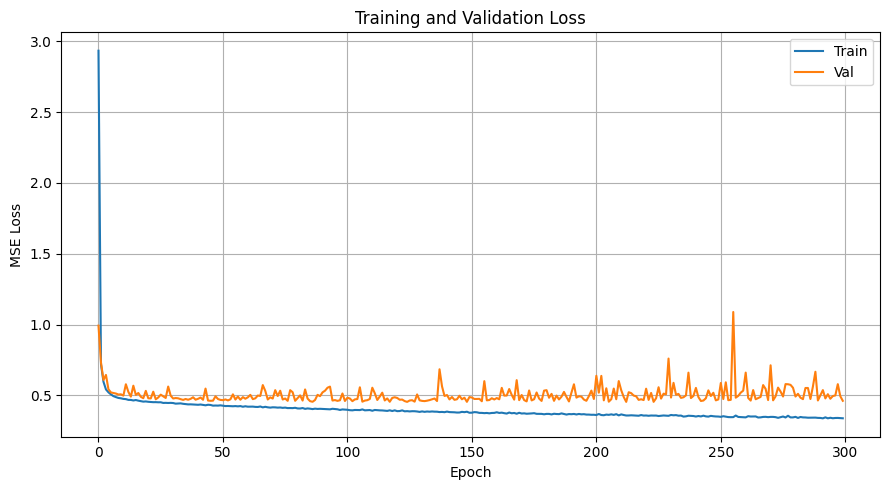

Saved: mlp_loss_curve.png


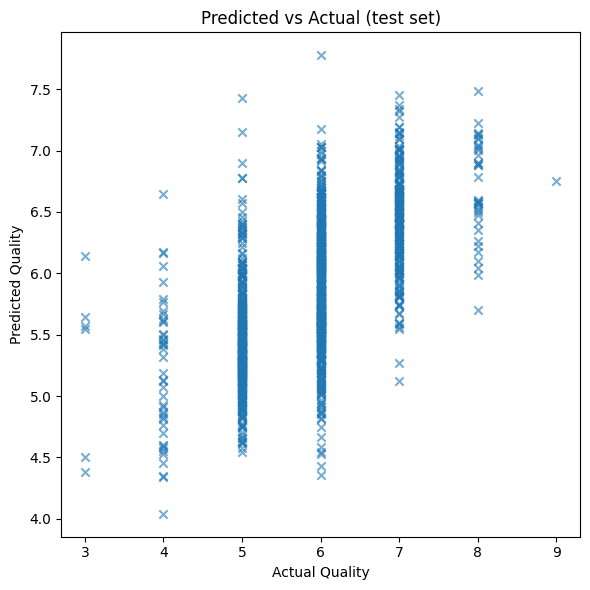

Saved: mlp_pred_vs_actual.png

Sample predictions (first 10):
 actual  predicted
    8.0   5.987050
    5.0   5.123878
    7.0   7.151999
    6.0   5.418850
    6.0   5.629915
    6.0   6.513226
    5.0   5.647423
    6.0   6.059702
    5.0   4.983915
    7.0   6.825676

Saved model parameters to mlp_params.npz

Artifacts present in C:\Users\aparn\Downloads\wine+quality
 - mlp_loss_curve.png True
 - mlp_pred_vs_actual.png True
 - mlp_params.npz True


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

DATA_DIR = r"C:\Users\aparn\Downloads\wine+quality"
np.random.seed(42)
if not os.path.isdir(DATA_DIR):
    print(f"Warning: {DATA_DIR} not found. Using current working directory: {os.getcwd()}")
else:
    os.chdir(DATA_DIR)
    print("Changed working directory to:", os.getcwd())

expected = ["winequality-red.csv", "winequality-white.csv"]
for fn in expected:
    if not os.path.exists(fn):
        raise FileNotFoundError(f"Expected '{fn}' in {os.getcwd()}")

red = pd.read_csv("winequality-red.csv", sep=";")
white = pd.read_csv("winequality-white.csv", sep=";")
red['type'] = 0
white['type'] = 1
data = pd.concat([red, white], ignore_index=True)

X = data.drop(columns=['quality']).values.astype(np.float64)
y = data['quality'].values.astype(np.float64).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, shuffle=True
)

scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

class MLP:
    def __init__(self, layer_sizes, activations, seed=42):
        assert len(layer_sizes)-1 == len(activations)
        self.layer_sizes = layer_sizes
        self.activations = activations
        self.params = {}
        rng = np.random.RandomState(seed)
        for i in range(len(layer_sizes)-1):
            n_in = layer_sizes[i]
            n_out = layer_sizes[i+1]
            limit = np.sqrt(6 / (n_in + n_out))
            W = rng.uniform(-limit, limit, size=(n_in, n_out))
            b = np.zeros((1, n_out))
            self.params[f"W{i+1}"] = W
            self.params[f"b{i+1}"] = b

    def _activation(self, x, name):
        if name == 'relu':
            return np.maximum(0, x)
        elif name == 'tanh':
            return np.tanh(x)
        elif name == 'sigmoid':
            return 1 / (1 + np.exp(-x))
        elif name == 'linear':
            return x
        else:
            raise ValueError("Unknown activation")

    def _activation_deriv(self, x, name):
        if name == 'relu':
            return (x > 0).astype(float)
        elif name == 'tanh':
            t = np.tanh(x); return 1 - t**2
        elif name == 'sigmoid':
            s = 1 / (1 + np.exp(-x)); return s * (1 - s)
        elif name == 'linear':
            return np.ones_like(x)
        else:
            raise ValueError("Unknown activation")

    def forward(self, X):
        caches = {'zs': [], 'as': []}
        a = X
        caches['as'].append(a)
        for i in range(len(self.layer_sizes)-1):
            W = self.params[f"W{i+1}"]
            b = self.params[f"b{i+1}"]
            z = a.dot(W) + b
            caches['zs'].append(z)
            a = self._activation(z, self.activations[i])
            caches['as'].append(a)
        return a, caches

    def compute_loss(self, y_pred, y_true):
        return np.mean((y_pred - y_true)**2)

    def backward(self, caches, y_pred, y_true):
        grads = {}
        m = y_true.shape[0]
        dA = (2.0 / m) * (y_pred - y_true)
        for i in reversed(range(len(self.layer_sizes)-1)):
            z = caches['zs'][i]
            a_prev = caches['as'][i]
            dz = dA * self._activation_deriv(z, self.activations[i])
            dW = a_prev.T.dot(dz)
            db = np.sum(dz, axis=0, keepdims=True)
            grads[f"dW{i+1}"] = dW
            grads[f"db{i+1}"] = db
            W = self.params[f"W{i+1}"]
            dA = dz.dot(W.T)
        return grads

    def update_params(self, grads, lr=0.001):
        for i in range(1, len(self.layer_sizes)):
            self.params[f"W{i}"] -= lr * grads[f"dW{i}"]
            self.params[f"b{i}"] -= lr * grads[f"db{i}"]

    def predict(self, X):
        y_pred, _ = self.forward(X)
        return y_pred

n_features = X_train_scaled.shape[1]
layer_sizes = [n_features, 64, 32, 1]
activations = ['relu', 'relu', 'linear']
mlp = MLP(layer_sizes, activations, seed=42)

epochs = 300
batch_size = 64
lr = 0.01

train_losses, val_losses = [], []
n_samples = X_train_scaled.shape[0]
steps_per_epoch = int(np.ceil(n_samples / batch_size))

for epoch in range(1, epochs+1):
    perm = np.random.permutation(n_samples)
    X_shuffled, y_shuffled = X_train_scaled[perm], y_train[perm]
    epoch_loss = 0.0
    for step in range(steps_per_epoch):
        start = step * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end]
        y_batch = y_shuffled[start:end]
        y_pred, caches = mlp.forward(X_batch)
        loss = mlp.compute_loss(y_pred, y_batch)
        epoch_loss += loss * X_batch.shape[0]
        grads = mlp.backward(caches, y_pred, y_batch)
        mlp.update_params(grads, lr=lr)
    epoch_loss /= n_samples
    y_val_pred = mlp.predict(X_test_scaled)
    val_loss = mlp.compute_loss(y_val_pred, y_test)
    train_losses.append(epoch_loss)
    val_losses.append(val_loss)
    if epoch % 25 == 0 or epoch in (1, epochs):
        print(f"Epoch {epoch:3d}/{epochs}  Train MSE: {epoch_loss:.4f}  Val MSE: {val_loss:.4f}")

y_test_pred = mlp.predict(X_test_scaled)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2 = r2_score(y_test, y_test_pred)

print("\nFinal evaluation on test set:")
print(f"Test MSE: {mse_test:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
print(f"Test R^2: {r2:.4f}")

plt.figure(figsize=(9,5))
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Val")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("mlp_loss_curve.png")
plt.show()
print("Saved: mlp_loss_curve.png")

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_test_pred, marker='x', alpha=0.6)
plt.xlabel("Actual Quality")
plt.ylabel("Predicted Quality")
plt.title("Predicted vs Actual (test set)")
plt.tight_layout()
plt.savefig("mlp_pred_vs_actual.png")
plt.show()
print("Saved: mlp_pred_vs_actual.png")

np.savez("mlp_params.npz", **mlp.params)
pred_df = pd.DataFrame({"actual": y_test.ravel(), "predicted": y_test_pred.ravel()})
print("\nSample predictions (first 10):")
print(pred_df.head(10).to_string(index=False))
print("\nSaved model parameters to mlp_params.npz")

print("\nArtifacts present in", os.getcwd())
for f in ["mlp_loss_curve.png", "mlp_pred_vs_actual.png", "mlp_params.npz"]:
    print(" -", f, os.path.exists(f))
